### Exercise 4: Prediction Uncertainty
- Pick a dataset and two continuous variables.
- Recall the LCLS estimator:
$$
\hat{y}(z) =  \frac{ \frac{1}{N} \sum_{i=1}^N y_i \times \frac{1}{h}k\left( \frac{z - x_i}{h} \right)}{ \frac{1}{N} \sum_{i=1}^N \frac{1}{h} k\left( \frac{z - x_i}{h} \right)}
$$
with the Epanechnikov kernel and the standard plug-in bandwidth for $h$

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../data/ames_prices.csv')
df.head(2)

,Order,PID,area,price,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,...,Screen.Porch,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition
0,1,526301100,1656,215000,20,RL,141.0,31770,Pave,NaN,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
1,2,526350040,896,105000,20,RH,80.0,11622,Pave,NaN,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal


In [33]:
# Grab two numeric variables
df = df.loc[:,['price', 'Lot.Frontage']]
df = df.dropna()
df = df.reset_index()
y = df['price']
x = df['Lot.Frontage']

- Compute and plot this line for 30 bootstrap samples. Notice where there is a lot of variation in the predictions, versus little variation in the predictions.

/tmp/ipykernel_51304/4215766047.py:20: RuntimeWarning: invalid value encountered in scalar divide
  y_hat_z = num/den
/tmp/ipykernel_51304/4215766047.py:20: RuntimeWarning: invalid value encountered in scalar divide
  y_hat_z = num/den
/tmp/ipykernel_51304/4215766047.py:20: RuntimeWarning: invalid value encountered in scalar divide
  y_hat_z = num/den
/tmp/ipykernel_51304/4215766047.py:20: RuntimeWarning: invalid value encountered in scalar divide
  y_hat_z = num/den
/tmp/ipykernel_51304/4215766047.py:20: RuntimeWarning: invalid value encountered in scalar divide
  y_hat_z = num/den
/tmp/ipykernel_51304/4215766047.py:20: RuntimeWarning: invalid value encountered in scalar divide
  y_hat_z = num/den
/tmp/ipykernel_51304/4215766047.py:20: RuntimeWarning: invalid value encountered in scalar divide
  y_hat_z = num/den
/tmp/ipykernel_51304/4215766047.py:20: RuntimeWarning: invalid value encountered in scalar divide
  y_hat_z = num/den
/tmp/ipykernel_51304/4215766047.py:20: RuntimeWarning: i

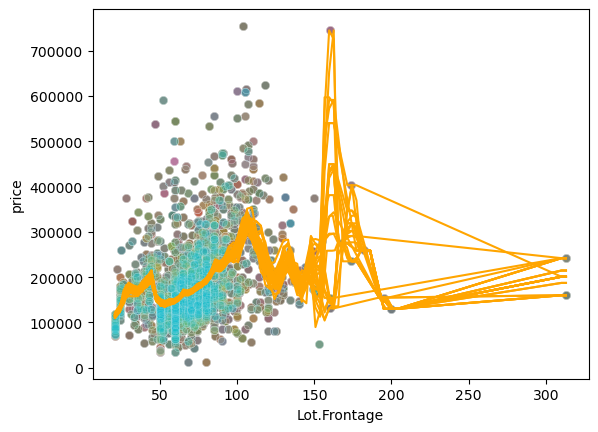

In [34]:
def lcls(x,y):
    grid = np.linspace( x.min(), x.max(), 100)
    N = len(x)
    h = 1.06 * np.std(x) * N**(-0.2)

    def kernel(u):
        '''Epanechnikov, for variety.'''
        k = .75 * (1-u**2) * int( np.abs(u) <= 1)
        return k

    # LCLS Regression:
    cef = []
    for z in grid:
        num = 0
        den = 0
        for i, data in enumerate(x):
            k_data = kernel( (z-data)/h )/(N*h)
            den += k_data
            num += y.iloc[i] * k_data
        y_hat_z = num/den
        cef.append(y_hat_z)

    sns.scatterplot(y=y,x=x,alpha = .1)
    sns.lineplot(x=grid,y=cef,color='orange')

estimates = [df.sample(frac=1.0,replace=True) for _ in range(30)]
for est in estimates:
    lcls(est['Lot.Frontage'],est['price'])
plt.show()

There seems to be significant variation in the predictions above 125 and little variation in the predictions below 125. This is because there are significantly more samples below 125 than above 125.

- Now, for any $z$, we can bootstrap a distribution of predictions using the above formula. Do this at the 25th percentile, median, and 75th percentile of $X$, and make KDE plots of your results.

In [35]:
def lcls(x,y, z):
    def kernel(u):
        '''Epanechnikov, for variety.'''
        k = .75 * (1-u**2) * int( np.abs(u) <= 1)
        return k
    N = len(x)
    h = 1.06 * np.std(x) * N**(-0.2)
    num = 0
    den = 0
    for i, data in enumerate(x):
        k_data = kernel( (z-data)/h )/(N*h)
        den += k_data
        num += y.iloc[i] * k_data
    return num/den
    

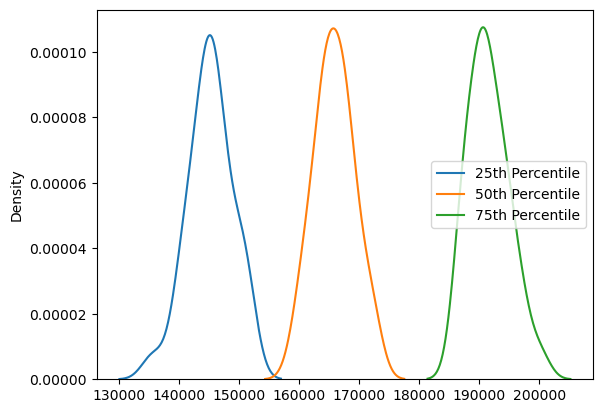

In [36]:
x = df['Lot.Frontage']
perc_25 = np.percentile(x, 25)
perc_50 = np.percentile(x, 50)
perc_75 = np.percentile(x, 75)
perc_25_preds = []
perc_50_preds = []
perc_75_preds = []
for i in range(30):
    x_boot = df.sample(frac=1.0,replace=True)
    perc_25_preds.append(lcls(x_boot['Lot.Frontage'],x_boot['price'],perc_25))
    perc_50_preds.append(lcls(x_boot['Lot.Frontage'],x_boot['price'],perc_50))
    perc_75_preds.append(lcls(x_boot['Lot.Frontage'],x_boot['price'],perc_75))
sns.kdeplot(perc_25_preds)
sns.kdeplot(perc_50_preds)
sns.kdeplot(perc_75_preds)
plt.legend(['25th Percentile','50th Percentile','75th Percentile'])
plt.show()

- Now, pick a grid for $z$: Obvious choices are all of the unique values in the data, or an equally spaced grid from the minimum value to the maximum value. For each $z$, bootstrap a sample of predictions and compute the .05 and .95 quantiles. Plot these error curves along with your LCLS estimate. Where are your predictions "tight"/reliable? Where are they highly variable/unreliable?

/tmp/ipykernel_51304/3831320258.py:14: RuntimeWarning: invalid value encountered in scalar divide
  return num/den


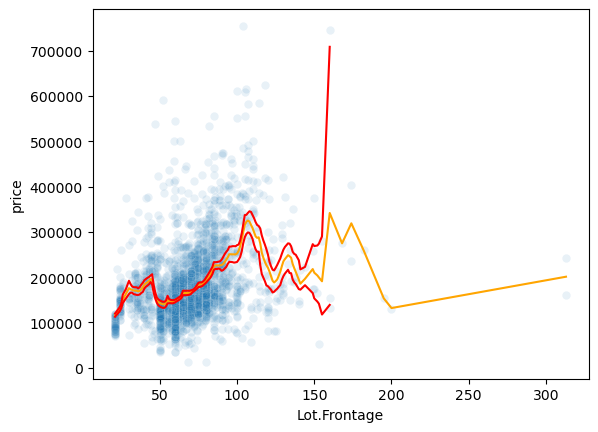

In [37]:
grid = np.unique(x)

# LCLS Regression:
N = len(x)
h = 1.06 * np.std(x) * N**(-0.2)
def kernel(u):
    '''Epanechnikov, for variety.'''
    k = .75 * (1-u**2) * int( np.abs(u) <= 1)
    return k
cef = []
for z in grid:
    num = 0
    den = 0
    for i, data in enumerate(x):
        k_data = kernel( (z-data)/h )/(N*h)
        den += k_data
        num += y.iloc[i] * k_data
    y_hat_z = num/den
    cef.append(y_hat_z)
sns.scatterplot(y=y,x=x,alpha = .1)
sns.lineplot(x=grid,y=cef,color='orange')

# Error Curves
boot_preds = np.zeros((30, len(grid)))
for i in range(30):
    df_boot = df.sample(frac=1.0,replace=True)
    x_boot = df_boot['Lot.Frontage']
    y_boot = df_boot['price']
    preds = [lcls(x_boot,y_boot,z) for z in grid]
    boot_preds[i, :] = preds
lower_band = np.percentile(boot_preds, 5, axis=0)
upper_band = np.percentile(boot_preds, 95, axis=0)
sns.lineplot(x=grid,y=lower_band,color='r')
sns.lineplot(x=grid,y=upper_band,color='r')
plt.show()

Our predictions are tight and reliable between 0 and ~125. After 125, it becomes extremely unreliable.